In [1]:
### Part 01. Load packages and libs

In [2]:
import os
import time
import warnings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

In [3]:
### Part 02. Writing a custom dataset for Blood Cell Segmemtation dataset, write data loader to load data for train model

In [4]:
TRAIN_IMG_DIR = "datasets/kvasir_capsule/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_capsule/train/masks"
VAL_IMG_DIR = "datasets/kvasir_capsule/test/images"
VAL_MASK_DIR = "datasets/kvasir_capsule/test/masks"

In [5]:
class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

In [6]:
def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [7]:
train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [8]:
BATCH_SIZE = 2

train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

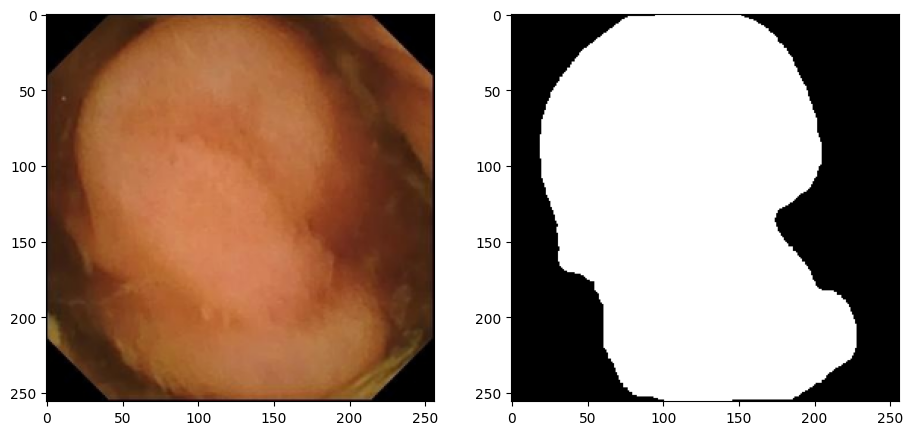

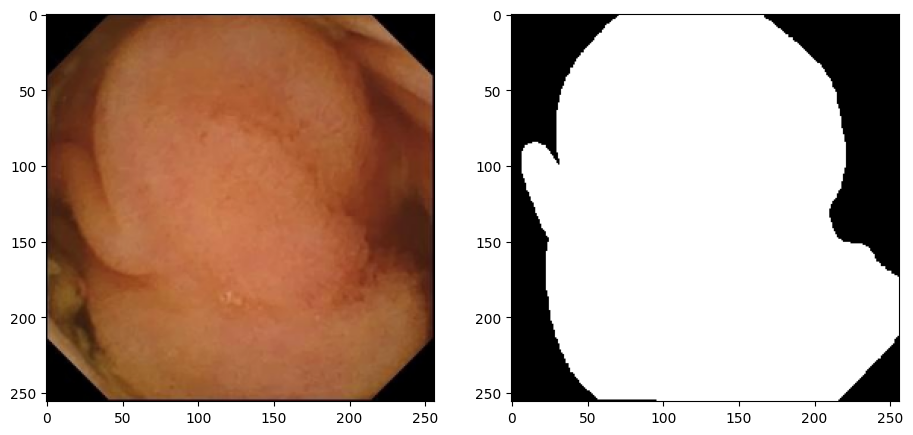

In [9]:
def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")


show_transformed(val_loader)

In [10]:
train_loader.dataset[0][0].shape
train_loader.dataset[0][1].shape

torch.Size([256, 256])

In [11]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               padding=1)  # 3 channels for RGB
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(
            64, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        return x

In [12]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

In [13]:
model = FCN(num_classes=1).to(DEVICE)
loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_loss = []
train_dice = []

def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [14]:
model

FCN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
print(model)

FCN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [16]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
            Conv2d-2        [-1, 128, 256, 256]          73,856
            Conv2d-3        [-1, 256, 256, 256]         295,168
   ConvTranspose2d-4        [-1, 128, 256, 256]         295,040
   ConvTranspose2d-5         [-1, 64, 256, 256]          73,792
   ConvTranspose2d-6          [-1, 1, 256, 256]             577
Total params: 740,225
Trainable params: 740,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 320.50
Params size (MB): 2.82
Estimated Total Size (MB): 324.07
----------------------------------------------------------------


In [17]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the Fully Convolutional Network (FCN) model is: {training_time:.2f} seconds")

Epoch: 1/32


100%|██████████| 22/22 [00:10<00:00,  2.03it/s, diceloss=0.789, iou=0.567]


Epoch: 1/32, IoU score: 0.5142141431570053
Epoch: 1/32, Total num_correct/num_pixels: 624018/720896 => 0.8656144738197327
Epoch: 1/32, Dice score: 0.8885306601953468
Epoch: 2/32


100%|██████████| 22/22 [00:10<00:00,  2.05it/s, diceloss=0.416, iou=0.779]


Epoch: 2/32, IoU score: 0.7372002384879373
Epoch: 2/32, Total num_correct/num_pixels: 662356/720896 => 0.9187955260276794
Epoch: 2/32, Dice score: 0.9294683020640214
Epoch: 3/32


100%|██████████| 22/22 [00:10<00:00,  2.06it/s, diceloss=0.25, iou=0.832] 


Epoch: 3/32, IoU score: 0.778894001787359
Epoch: 3/32, Total num_correct/num_pixels: 656219/720896 => 0.9102824926376343
Epoch: 3/32, Dice score: 0.9234505504959705
Epoch: 4/32


100%|██████████| 22/22 [00:10<00:00,  2.02it/s, diceloss=0.544, iou=0.756]


Epoch: 4/32, IoU score: 0.7849388908256184
Epoch: 4/32, Total num_correct/num_pixels: 667942/720896 => 0.926544189453125
Epoch: 4/32, Dice score: 0.9371317787393769
Epoch: 5/32


100%|██████████| 22/22 [00:11<00:00,  1.99it/s, diceloss=0.516, iou=0.789]


Epoch: 5/32, IoU score: 0.7937306301160292
Epoch: 5/32, Total num_correct/num_pixels: 661495/720896 => 0.9176011681556702
Epoch: 5/32, Dice score: 0.9304662639621442
Epoch: 6/32


100%|██████████| 22/22 [00:10<00:00,  2.03it/s, diceloss=0.356, iou=0.783]


Epoch: 6/32, IoU score: 0.8032065575773065
Epoch: 6/32, Total num_correct/num_pixels: 661660/720896 => 0.9178300499916077
Epoch: 6/32, Dice score: 0.927518736237571
Epoch: 7/32


100%|██████████| 22/22 [00:10<00:00,  2.05it/s, diceloss=0.693, iou=0.721]


Epoch: 7/32, IoU score: 0.8007638454437256
Epoch: 7/32, Total num_correct/num_pixels: 669957/720896 => 0.9293393492698669
Epoch: 7/32, Dice score: 0.9391535629248511
Epoch: 8/32


100%|██████████| 22/22 [00:10<00:00,  2.04it/s, diceloss=0.609, iou=0.763]


Epoch: 8/32, IoU score: 0.8088086951862682
Epoch: 8/32, Total num_correct/num_pixels: 666890/720896 => 0.9250849485397339
Epoch: 8/32, Dice score: 0.9368034665830782
Epoch: 9/32


100%|██████████| 22/22 [00:10<00:00,  2.02it/s, diceloss=0.471, iou=0.708]


Epoch: 9/32, IoU score: 0.8038369715213776
Epoch: 9/32, Total num_correct/num_pixels: 668807/720896 => 0.9277440905570984
Epoch: 9/32, Dice score: 0.9386538758876772
Epoch: 10/32


100%|██████████| 22/22 [00:10<00:00,  2.03it/s, diceloss=0.308, iou=0.82] 


Epoch: 10/32, IoU score: 0.8108227550983429
Epoch: 10/32, Total num_correct/num_pixels: 670831/720896 => 0.9305517077445984
Epoch: 10/32, Dice score: 0.9402324000484283
Epoch: 11/32


100%|██████████| 22/22 [00:10<00:00,  2.04it/s, diceloss=0.224, iou=0.843]


Epoch: 11/32, IoU score: 0.8102833845398643
Epoch: 11/32, Total num_correct/num_pixels: 670957/720896 => 0.9307265281677246
Epoch: 11/32, Dice score: 0.9406521563776769
Epoch: 12/32


100%|██████████| 22/22 [00:10<00:00,  2.02it/s, diceloss=0.511, iou=0.744]


Epoch: 12/32, IoU score: 0.8166664134372364
Epoch: 12/32, Total num_correct/num_pixels: 671783/720896 => 0.9318723082542419
Epoch: 12/32, Dice score: 0.941656215391099
Epoch: 13/32


100%|██████████| 22/22 [00:11<00:00,  1.98it/s, diceloss=0.414, iou=0.816]


Epoch: 13/32, IoU score: 0.8034140061248433
Epoch: 13/32, Total num_correct/num_pixels: 671676/720896 => 0.9317238926887512
Epoch: 13/32, Dice score: 0.9413201640183724
Epoch: 14/32


100%|██████████| 22/22 [00:10<00:00,  2.00it/s, diceloss=0.313, iou=0.827]


Epoch: 14/32, IoU score: 0.7779749686067755
Epoch: 14/32, Total num_correct/num_pixels: 671408/720896 => 0.9313521385192871
Epoch: 14/32, Dice score: 0.9406373822937166
Epoch: 15/32


100%|██████████| 22/22 [00:11<00:00,  1.98it/s, diceloss=0.334, iou=0.827]


Epoch: 15/32, IoU score: 0.8132526468146931
Epoch: 15/32, Total num_correct/num_pixels: 671630/720896 => 0.9316600561141968
Epoch: 15/32, Dice score: 0.9412792721345522
Epoch: 16/32


100%|██████████| 22/22 [00:11<00:00,  1.97it/s, diceloss=0.533, iou=0.774]


Epoch: 16/32, IoU score: 0.8196650689298456
Epoch: 16/32, Total num_correct/num_pixels: 672401/720896 => 0.9327296018600464
Epoch: 16/32, Dice score: 0.9420328454304144
Epoch: 17/32


100%|██████████| 22/22 [00:11<00:00,  1.95it/s, diceloss=0.536, iou=0.78] 


Epoch: 17/32, IoU score: 0.803664974190972
Epoch: 17/32, Total num_correct/num_pixels: 669508/720896 => 0.9287165403366089
Epoch: 17/32, Dice score: 0.9395969261559092
Epoch: 18/32


100%|██████████| 22/22 [00:11<00:00,  1.96it/s, diceloss=0.253, iou=0.829]


Epoch: 18/32, IoU score: 0.8171550766988234
Epoch: 18/32, Total num_correct/num_pixels: 672599/720896 => 0.9330042600631714
Epoch: 18/32, Dice score: 0.9415164230031658
Epoch: 19/32


100%|██████████| 22/22 [00:11<00:00,  1.95it/s, diceloss=0.214, iou=0.864]


Epoch: 19/32, IoU score: 0.8141362233595415
Epoch: 19/32, Total num_correct/num_pixels: 673402/720896 => 0.9341181516647339
Epoch: 19/32, Dice score: 0.9429020224210702
Epoch: 20/32


100%|██████████| 22/22 [00:11<00:00,  1.96it/s, diceloss=0.213, iou=0.849]


Epoch: 20/32, IoU score: 0.8127781857143749
Epoch: 20/32, Total num_correct/num_pixels: 671376/720896 => 0.9313077330589294
Epoch: 20/32, Dice score: 0.9417147340007259
Epoch: 21/32


100%|██████████| 22/22 [00:11<00:00,  1.95it/s, diceloss=0.315, iou=0.815]


Epoch: 21/32, IoU score: 0.8224296109242872
Epoch: 21/32, Total num_correct/num_pixels: 673461/720896 => 0.9341999888420105
Epoch: 21/32, Dice score: 0.9432489615138877
Epoch: 22/32


100%|██████████| 22/22 [00:11<00:00,  1.93it/s, diceloss=0.318, iou=0.844]


Epoch: 22/32, IoU score: 0.8119984458793293
Epoch: 22/32, Total num_correct/num_pixels: 672881/720896 => 0.9333953857421875
Epoch: 22/32, Dice score: 0.9430423198979885
Epoch: 23/32


100%|██████████| 22/22 [00:11<00:00,  1.95it/s, diceloss=0.234, iou=0.844]


Epoch: 23/32, IoU score: 0.8124068108471957
Epoch: 23/32, Total num_correct/num_pixels: 669989/720896 => 0.9293837547302246
Epoch: 23/32, Dice score: 0.9404625828836655
Epoch: 24/32


100%|██████████| 22/22 [00:11<00:00,  1.94it/s, diceloss=0.253, iou=0.844]


Epoch: 24/32, IoU score: 0.8131537925113331
Epoch: 24/32, Total num_correct/num_pixels: 673727/720896 => 0.9345689415931702
Epoch: 24/32, Dice score: 0.9437600962567108
Epoch: 25/32


100%|██████████| 22/22 [00:11<00:00,  1.95it/s, diceloss=0.703, iou=0.731]


Epoch: 25/32, IoU score: 0.8248971863226457
Epoch: 25/32, Total num_correct/num_pixels: 674168/720896 => 0.9351806640625
Epoch: 25/32, Dice score: 0.944297424706147
Epoch: 26/32


100%|██████████| 22/22 [00:11<00:00,  1.92it/s, diceloss=0.261, iou=0.852]


Epoch: 26/32, IoU score: 0.8007305047728799
Epoch: 26/32, Total num_correct/num_pixels: 671324/720896 => 0.9312356114387512
Epoch: 26/32, Dice score: 0.9416323483656583
Epoch: 27/32


100%|██████████| 22/22 [00:11<00:00,  1.93it/s, diceloss=0.204, iou=0.846]


Epoch: 27/32, IoU score: 0.824884065172889
Epoch: 27/32, Total num_correct/num_pixels: 674107/720896 => 0.9350960850715637
Epoch: 27/32, Dice score: 0.9439215598721247
Epoch: 28/32


100%|██████████| 22/22 [00:11<00:00,  1.92it/s, diceloss=0.576, iou=0.767]


Epoch: 28/32, IoU score: 0.8133676485581831
Epoch: 28/32, Total num_correct/num_pixels: 672843/720896 => 0.933342695236206
Epoch: 28/32, Dice score: 0.9430895125561485
Epoch: 29/32


100%|██████████| 22/22 [00:11<00:00,  1.93it/s, diceloss=0.206, iou=0.871]


Epoch: 29/32, IoU score: 0.8157885481010784
Epoch: 29/32, Total num_correct/num_pixels: 673807/720896 => 0.9346799254417419
Epoch: 29/32, Dice score: 0.9439883969690881
Epoch: 30/32


100%|██████████| 22/22 [00:11<00:00,  1.89it/s, diceloss=0.421, iou=0.792]


Epoch: 30/32, IoU score: 0.8207570829174735
Epoch: 30/32, Total num_correct/num_pixels: 674157/720896 => 0.9351654052734375
Epoch: 30/32, Dice score: 0.9444075966404231
Epoch: 31/32


100%|██████████| 22/22 [00:11<00:00,  1.90it/s, diceloss=0.235, iou=0.855]


Epoch: 31/32, IoU score: 0.8159962296485901
Epoch: 31/32, Total num_correct/num_pixels: 671631/720896 => 0.9316614866256714
Epoch: 31/32, Dice score: 0.9423060797758911
Epoch: 32/32


100%|██████████| 22/22 [00:11<00:00,  1.90it/s, diceloss=0.276, iou=0.846]


Epoch: 32/32, IoU score: 0.8124204603108492
Epoch: 32/32, Total num_correct/num_pixels: 673198/720896 => 0.9338351488113403
Epoch: 32/32, Dice score: 0.943623011984208
done ..
The training time of the Fully Convolutional Network (FCN) model is: 367.45 seconds


In [18]:
print(train_loss)

[0.882763995365663, 0.4861250153996728, 0.4362891702489419, 0.4115731573917649, 0.38484755090691825, 0.37953549149361526, 0.38371672887693753, 0.361151474443349, 0.36720393327149475, 0.35595743967728183, 0.3515524979342114, 0.3504614531993866, 0.3858456523580985, 0.4014339487661015, 0.3616121011701497, 0.350275536829775, 0.35116223855452106, 0.346750791777264, 0.3498563610694625, 0.34939008341594174, 0.3426367444070903, 0.3420451581478119, 0.33786874603141437, 0.34767440232363617, 0.33881571888923645, 0.35195171494375577, 0.34770530462265015, 0.3367800468748266, 0.3414910679513758, 0.3334460170431571, 0.349748432636261, 0.3580196709795432]


In [19]:
print(train_iou)

[0.5142141431570053, 0.7372002384879373, 0.778894001787359, 0.7849388908256184, 0.7937306301160292, 0.8032065575773065, 0.8007638454437256, 0.8088086951862682, 0.8038369715213776, 0.8108227550983429, 0.8102833845398643, 0.8166664134372364, 0.8034140061248433, 0.7779749686067755, 0.8132526468146931, 0.8196650689298456, 0.803664974190972, 0.8171550766988234, 0.8141362233595415, 0.8127781857143749, 0.8224296109242872, 0.8119984458793293, 0.8124068108471957, 0.8131537925113331, 0.8248971863226457, 0.8007305047728799, 0.824884065172889, 0.8133676485581831, 0.8157885481010784, 0.8207570829174735, 0.8159962296485901, 0.8124204603108492]


In [20]:
print(train_dice)

[tensor(0.8885, device='cuda:0', dtype=torch.float64), tensor(0.9295, device='cuda:0', dtype=torch.float64), tensor(0.9235, device='cuda:0', dtype=torch.float64), tensor(0.9371, device='cuda:0', dtype=torch.float64), tensor(0.9305, device='cuda:0', dtype=torch.float64), tensor(0.9275, device='cuda:0', dtype=torch.float64), tensor(0.9392, device='cuda:0', dtype=torch.float64), tensor(0.9368, device='cuda:0', dtype=torch.float64), tensor(0.9387, device='cuda:0', dtype=torch.float64), tensor(0.9402, device='cuda:0', dtype=torch.float64), tensor(0.9407, device='cuda:0', dtype=torch.float64), tensor(0.9417, device='cuda:0', dtype=torch.float64), tensor(0.9413, device='cuda:0', dtype=torch.float64), tensor(0.9406, device='cuda:0', dtype=torch.float64), tensor(0.9413, device='cuda:0', dtype=torch.float64), tensor(0.9420, device='cuda:0', dtype=torch.float64), tensor(0.9396, device='cuda:0', dtype=torch.float64), tensor(0.9415, device='cuda:0', dtype=torch.float64), tensor(0.9429, device='cuda

In [21]:
train_dice = [t.cpu().item() for t in train_dice]

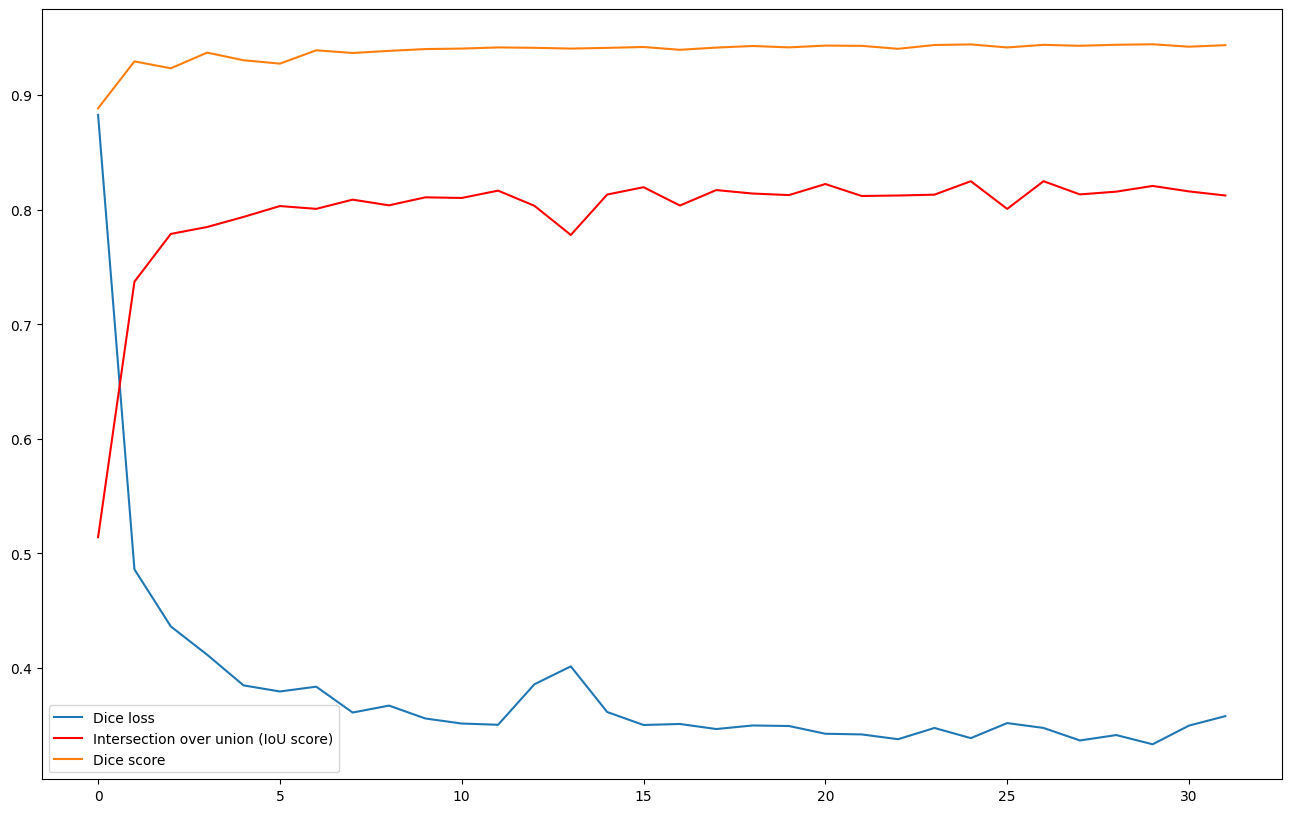

In [22]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
# plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_iou, label='Intersection over union (IoU score)', color='red')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [23]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou


# Run the test function
avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 6/6 [00:00<00:00, 18.98it/s]

Average Dice Score: 0.9436
Average IoU Score: 0.5244


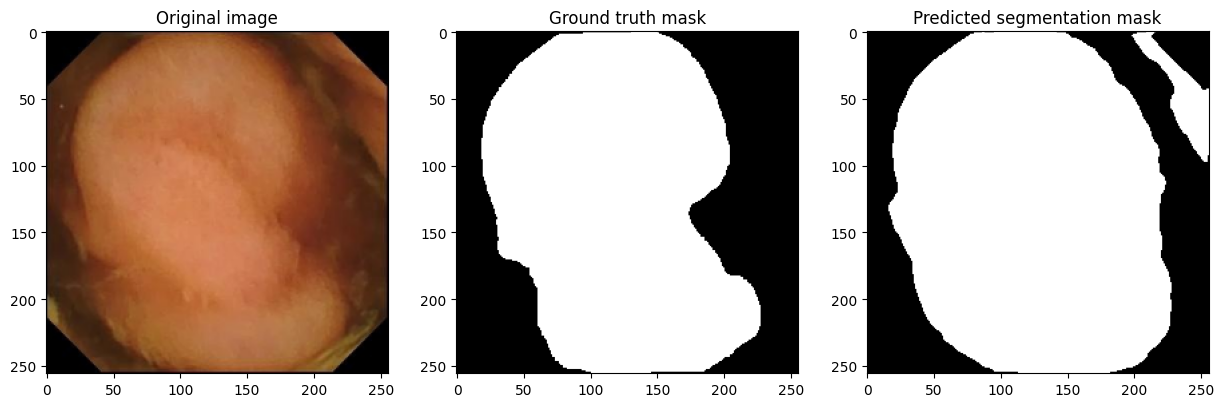

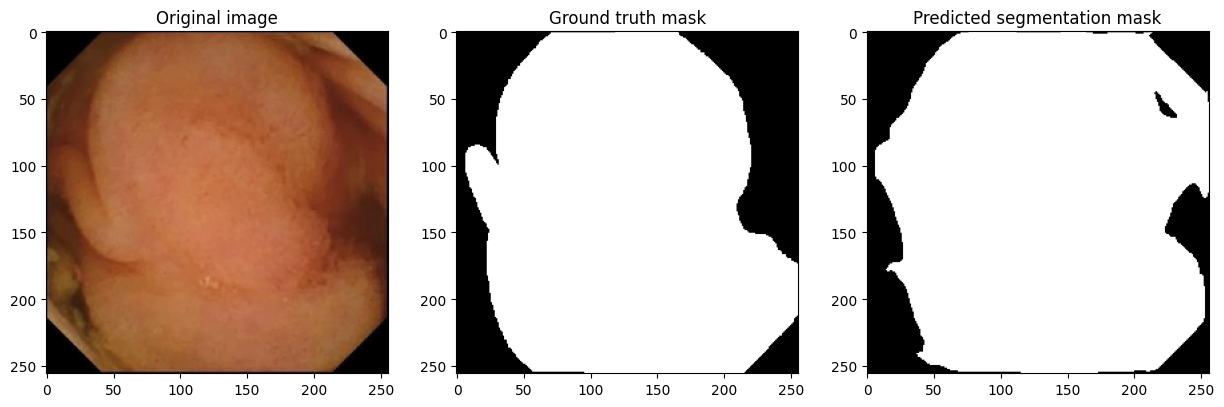

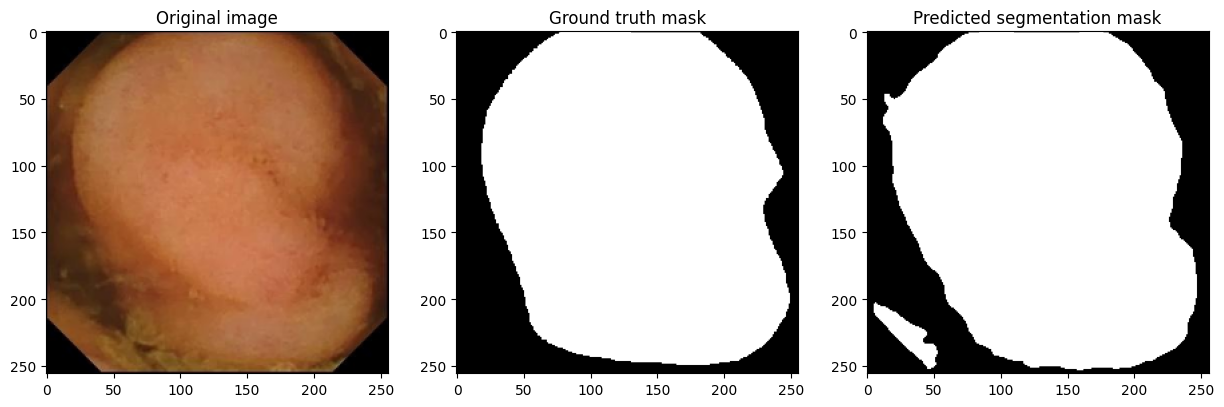

In [24]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                # Ground Truth
                plt.subplot(1, 3, 2)
                plt.title("Ground truth mask")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                # Predicted Mask
                plt.subplot(1, 3, 3)
                plt.title("Predicted segmentation mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break


visualize_predictions(model, val_loader, DEVICE)

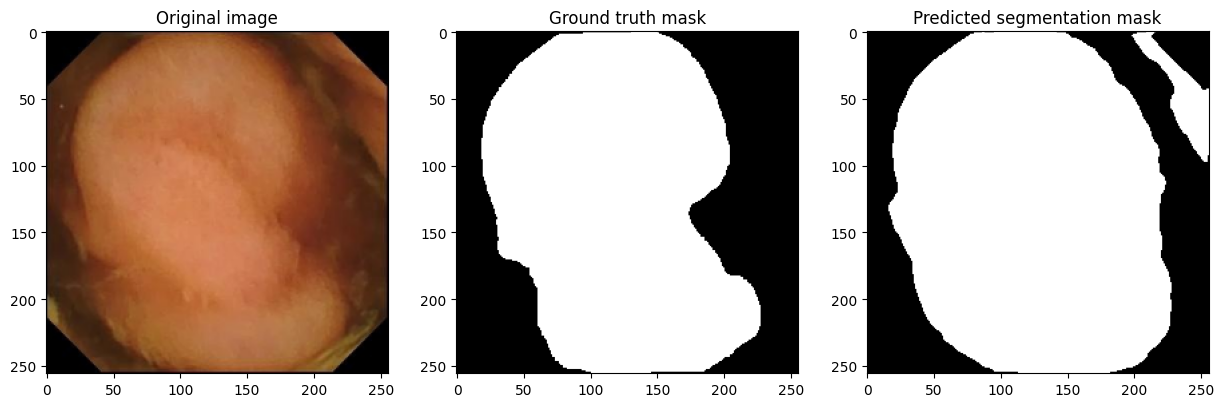

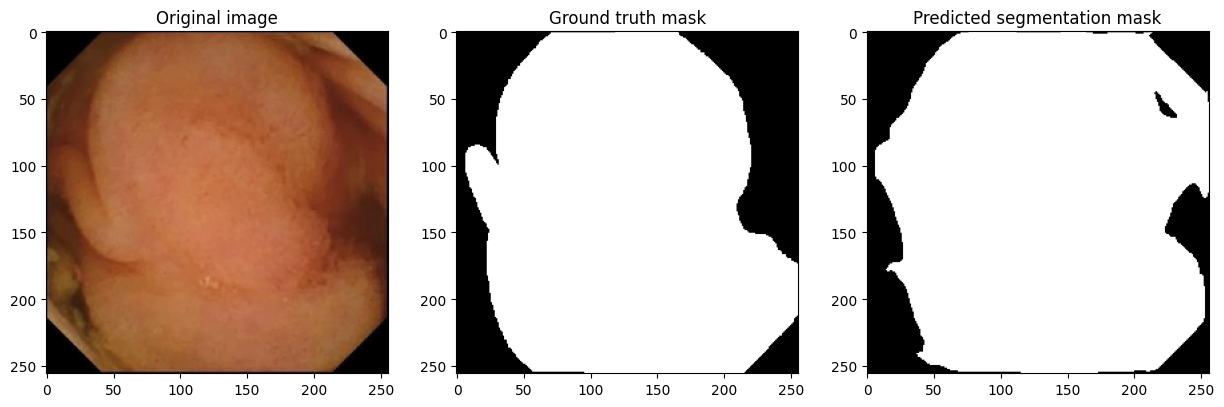

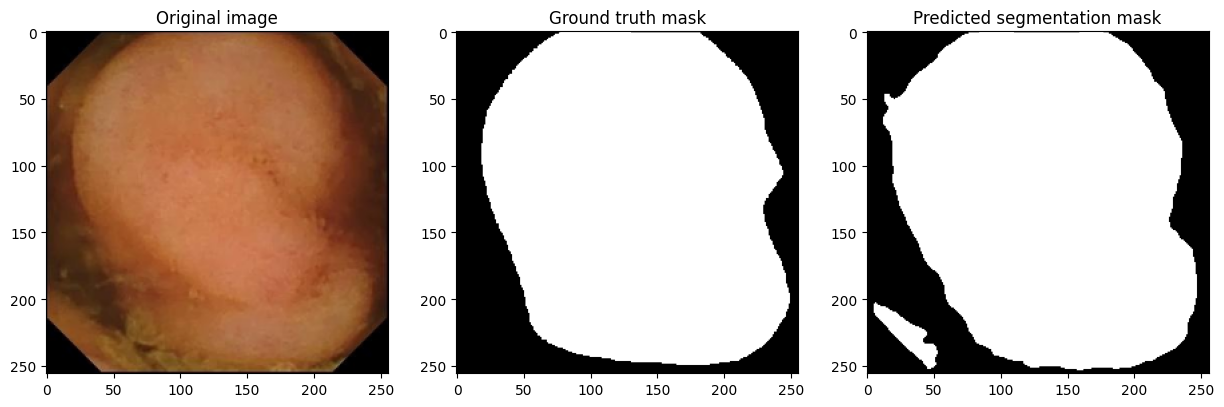

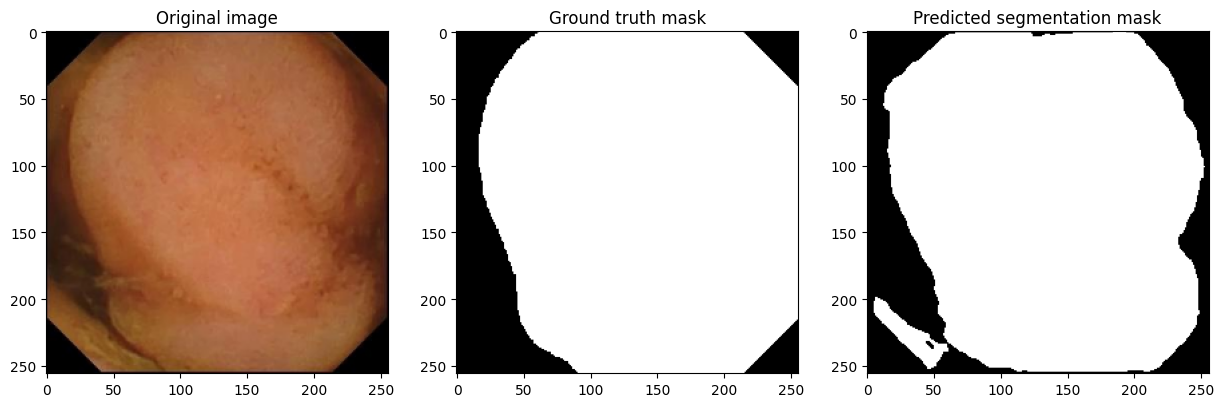

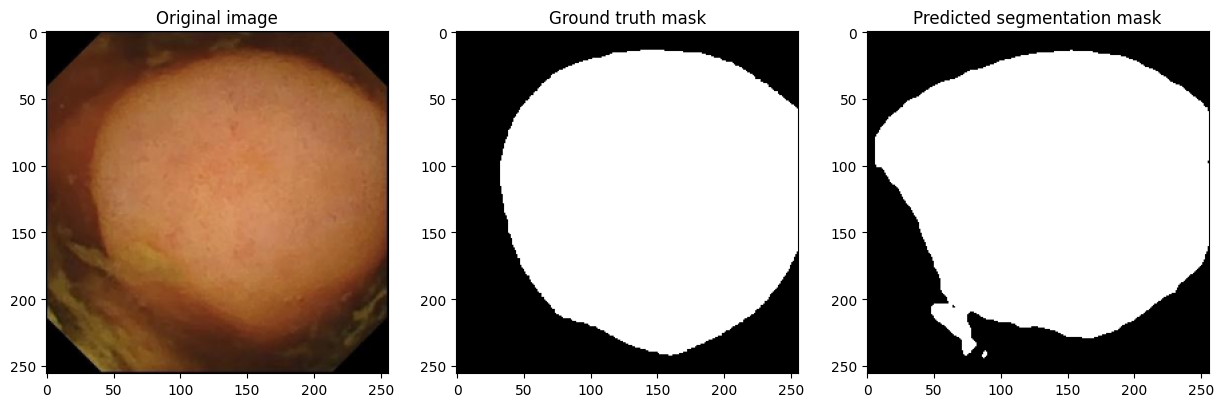

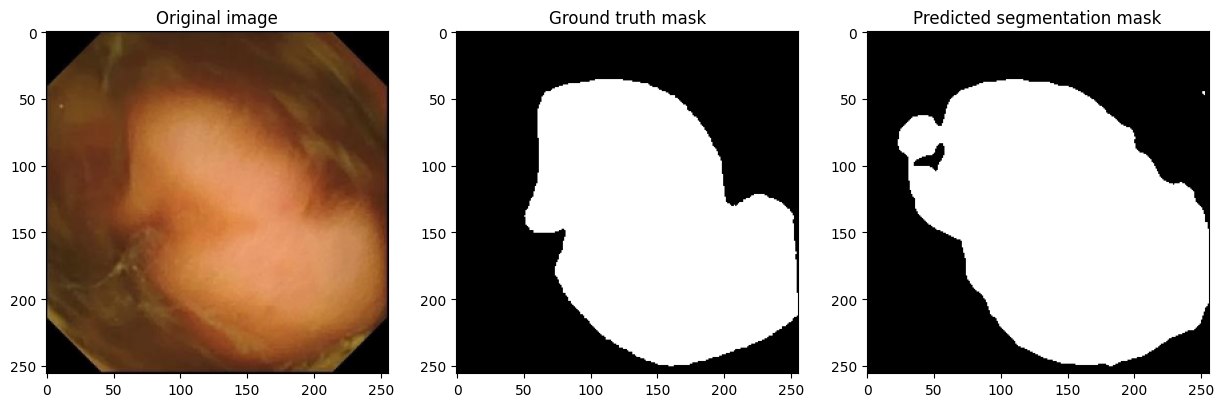

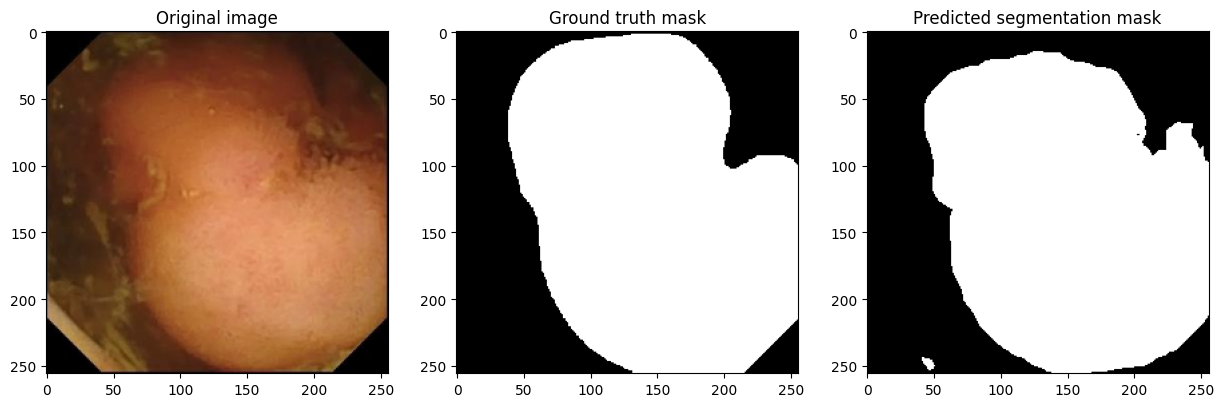

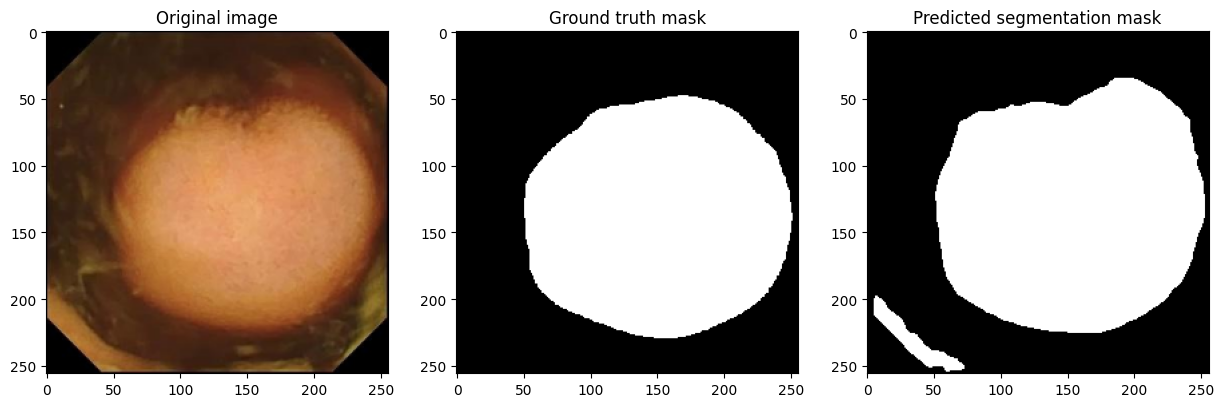

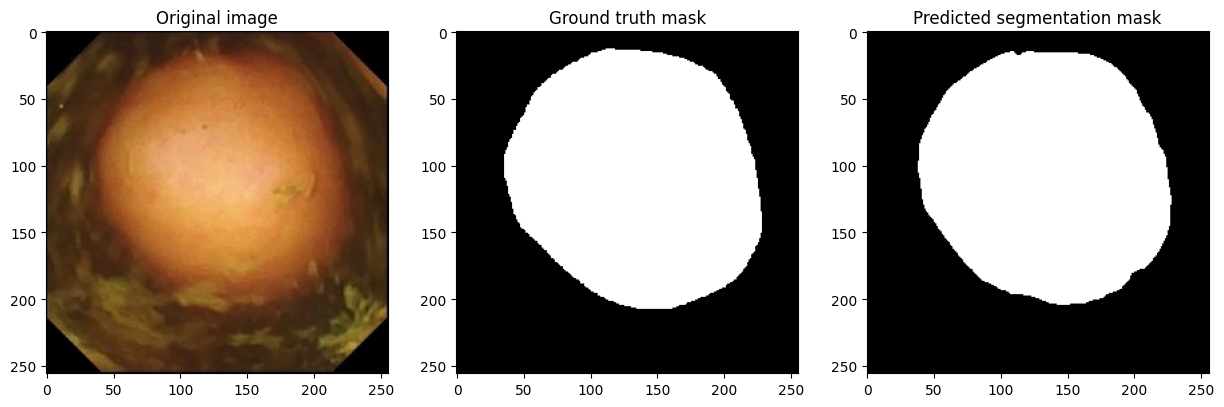

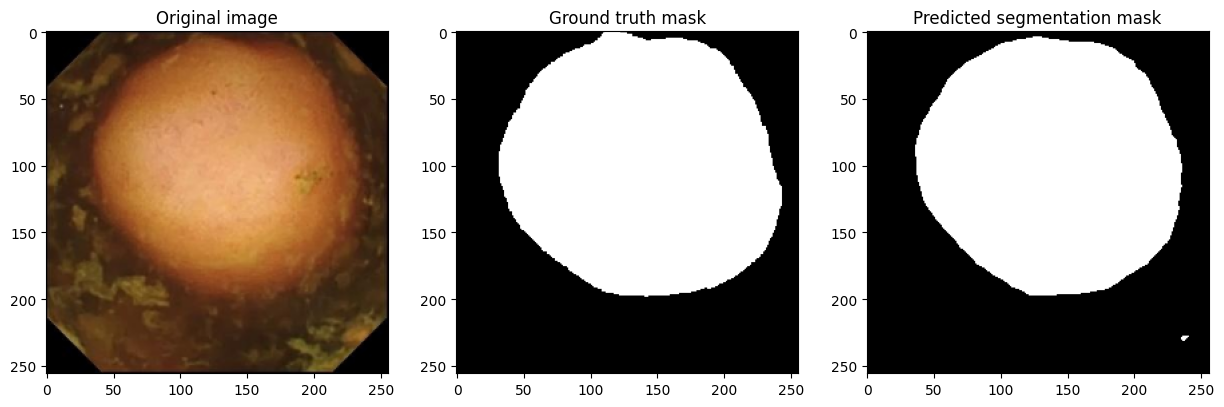

In [25]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)